In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

In [3]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='log_loss', random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.8333333333333334

In [4]:
from sklearn.linear_model import SGDClassifier
# 선형 서포트 벡터 머신(Support Vector Machine:SVM) 문제를 푸는 모델로 바뀜 (log -> hinge)
sgd = SGDClassifier(loss='hinge', random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.9385964912280702

테스트 세트는 실전에 투입된 모델의 성능 측정을 위해 사용  
그런데 테스트 세트로 모델을 튜닝하면 테스트 세트에 대해서만 좋은 성능을 보여주는 모델이 된다  
모델의 일반화 성능이 왜곡 된다거나, 낙관적으로 성능을 추정한다고도 표현함  

테스트 세트는 모델 튜닝을 모두 마치고 실전에 투입하기 전 딱 한번에 한하여 사용하는 것이 좋음  
모델 튜닝을 위한 세트는 따로 준비해야 함  
모델을 튜닝하는 용도의 세트는 검증 세트라고 하며 훈련 세트를 조금 떼어 만듦  

In [5]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

In [7]:
# 훈련 검증 테스트 세트는 6:2:2로 분할
# 전체 데이터 세트를 8:2로 나눈 후 테스트 세트를 만들고
# 다시 8을 8:2로 나누어 검증 세트 만듦 64:20:16 정도
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)
print(len(x_train), len(x_val))

364 91


In [8]:
sgd = SGDClassifier(loss='log_loss', random_state=42)
sgd.fit(x_train, y_train)
sgd.score(x_val, y_val)

0.6923076923076923

훈련 데이터가 줄어서 점수가 낮아짐  

### 데이터 전처리와 특성의 스케일
실전에서 수집된 데이터는 누락된 값이나 데이터의 형태가 균일하지 않을 수 있다. 이런 데이터들의 경우 가공하지 않으면 제대로 된 결과를 얻기 힘듦, 이때 적절히 가공하는 데이터 전처리 과정이 필요함
- 특성의 스케일은 알고리즘에 영향을 끼침  
  잘 정리된 데이터의 경우에도 **스케일**이 다를 경우 전처리를 해야함  
  *스케일이란?*
  특성이 가지고 있는 값의 범위
- 경사 하강법은 스케일에 민감한 알고리즘  
- 특성의 스케일을 전처리 하는 것을 스케일을 조정한다고 표현함  

## 스케일 조정 X

In [9]:
import matplotlib.pyplot as plt
import numpy as np

['mean perimeter' 'mean area']


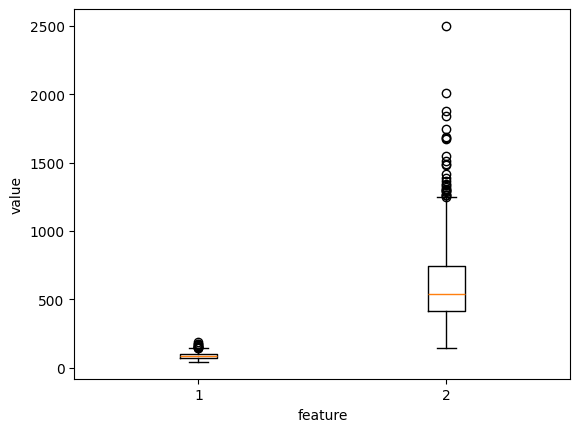

In [10]:
print(cancer.feature_names[[2, 3]])
plt.boxplot(x_train[:, 2:4])
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

학습률이 너무 커, (가중치를 큰 폭으로 업데이트하면) 손실 함수가 최소가 될 수 있는 지점인 전역 최솟값을 지나쳐 버리게 되어 최적의 해르 ㄹ구할 수 없게 됨. 고로 전역 최솟값을 놓치지 않도록 가중치의 업데이트 양을 조절할 필요가 있음  
> 보통 0.001, 0.01 등 로그 스케일로 학습률을 지정함

In [11]:
class SingleLayer:
  def __init__(self, learning_rate=0.1):
    self.w = None
    self.b = None
    self.losses = []
    self.w_history = []
    self.lr = learning_rate # 학습률: 가중치의 업데이트 양을 조절

  def forpass(self, x):
    z = np.sum(x * self.w) + self.b
    return z

  def backdrop(self, x, err):
    w_grad = x * err
    b_grad = 1 * err
    return w_grad, b_grad

  def activation(self, z):
    a = 1 / (1 + np.exp(-z)) # 시그모이드 계산
    return a

  def fit(self, x, y, epochs=100):
    self.w = np.ones(x.shape[1]) # 가중치 초기화
    self.b = 0 # 절편 초기화
    self.w_history.append(self.w.copy())
    np.random.seed(42)
    for i in range(epochs):
      loss = 0
      indexes = np.random.permutation(np.arange(len(x))) # 인덱스 섞기

      for i in indexes:
        z = self.forpass(x[i])
        a = self.activation(z)
        err = -(y[i] - a)
        w_grad, b_grad = self.backdrop(x[i], err)
        self.w -= self.lr * w_grad
        self.b -= self.lr * b_grad

        self.w_history.append(self.w.copy())

        a = np.clip(a, 1e-10, 1-1e-10)
        loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
      self.losses.append(loss/len(y))

  def predict(self, x):
    z = [self.forpass(x_i) for x_i in x] # 정방향 계산
    return np.array(z) > 0

  def score(self, x, y):
    return np.mean(self.predict(x) == y)


In [13]:
layer1 = SingleLayer()
layer1.fit(x_train, y_train)
layer1.score(x_val, y_val)

<ipython-input-11-2d097d89df1c>:19: RuntimeWarning: overflow encountered in exp
  a = 1 / (1 + np.exp(-z)) # 시그모이드 계산


np.float64(0.9120879120879121)

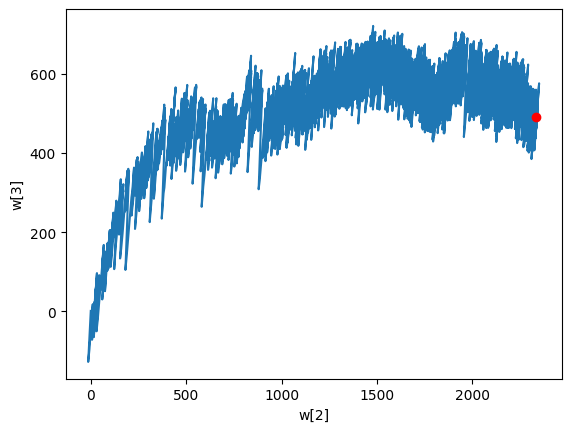

In [14]:
w2 = []
w3 = []
for w in layer1.w_history:
  w2.append(w[2])
  w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

## 표준화 : 스케일 조정 방법
특성값에서 평균을 빼고 표준 편차로 나누면 됨
$$z=\frac{x-u}{s}$$

In [15]:
train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train, axis=0)
x_train_scaled = (x_train - train_mean) / train_std

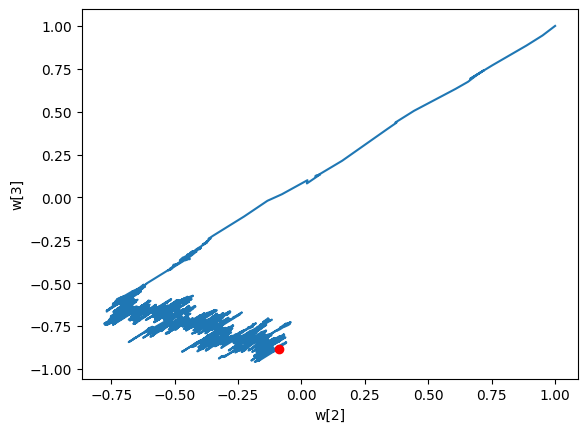

In [16]:
layer2 = SingleLayer()
layer2.fit(x_train_scaled, y_train)
w2 = []
w3 = []

for w in layer2.w_history:
  w2.append(w[2])
  w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

In [18]:
layer2.score(x_val, y_val)

np.float64(0.37362637362637363)

In [19]:
val_mean = np.mean(x_val, axis=0)
val_std = np.std(x_val, axis=0)
x_val_scaled = (x_val - val_mean) / val_std
layer2.score(x_val_scaled, y_val)

np.float64(0.967032967032967)

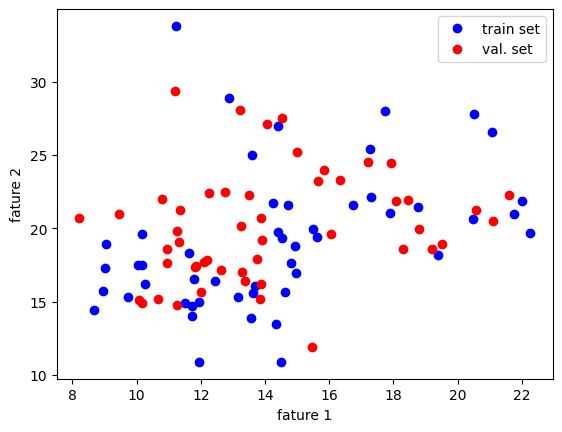

In [21]:
plt.plot(x_train[:50, 0], x_train[:50, 1], 'bo')
plt.plot(x_val[:50, 0], x_val[:50, 1], 'ro')
plt.xlabel('fature 1')
plt.ylabel('fature 2')
plt.legend(['train set', 'val. set'])
plt.show()

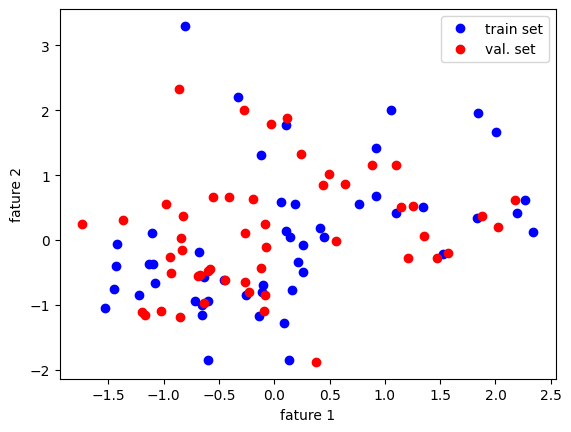

In [22]:
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')
plt.xlabel('fature 1')
plt.ylabel('fature 2')
plt.legend(['train set', 'val. set'])
plt.show()

훈련 세트와 검증 세트의 거리가 달라진 이유는 훈련 세트와 검증 세트를 각각 다른 비율로 전처리 했기 때문  

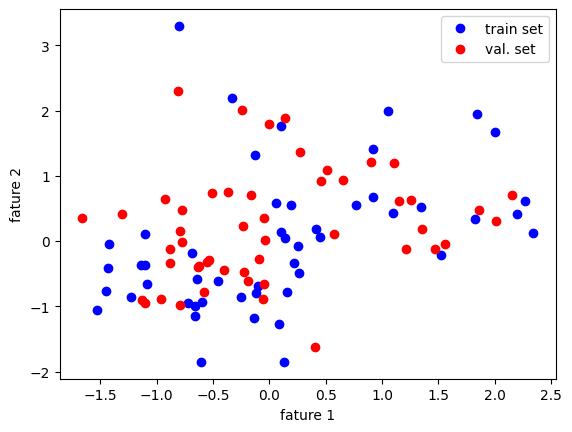

In [23]:
x_val_scaled = (x_val - train_mean) / train_std
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')
plt.xlabel('fature 1')
plt.ylabel('fature 2')
plt.legend(['train set', 'val. set'])
plt.show()

In [24]:
layer2.score(x_val_scaled, y_val)

np.float64(0.967032967032967)